# Fast RCNN - Backbone ResNet

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the data

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
import albumentations as A
import torchsummary
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [ ]:
torch.cuda.empty_cache()

BS=16
IS=256
D='cuda' if torch.cuda.is_available() else 'cpu'

### Class

In [ ]:
num_classes = 7
classes=['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
c2l={k:v for k,v in list(zip(classes,list(range(num_classes))))}
l2c={v:k for k,v in c2l.items()}


### deklarasi data train dan validasi

In [ ]:
dir_path='/content/drive/MyDrive/BoneFractureYolo8'
train_dir_path='/content/drive/MyDrive/BoneFractureYolo8/train'
train_img_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/train/images'))
train_target_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/train/labels'))

val_dir_path='/content/drive/MyDrive/BoneFractureYolo8/valid'
val_img_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/valid/images'))
val_target_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/valid/labels'))

### Load data

In [ ]:
def unconvert(width, height, x, y, w, h):

    xmax = int((x*width) + (w * width)/2.0)
    xmin = int((x*width) - (w * width)/2.0)
    ymax = int((y*height) + (h * height)/2.0)
    ymin = int((y*height) - (h * height)/2.0)

    return xmin, ymin, xmax, ymax

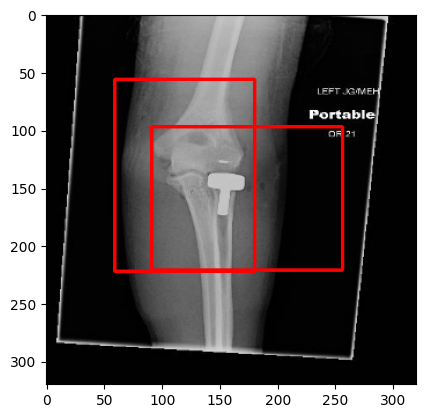

In [ ]:
idx=random.randint(0,3000)
# idx=0
ip=os.path.join(train_dir_path,'images',train_img_paths[idx])
tp=os.path.join(train_dir_path,'labels',train_target_paths[idx])

image=cv2.imread(ip)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(320,320))

file=open(tp,'r')
target=list(map(float,file.read().split()))[1:]

a=0
while a<len(target):
    bbox=target[a:a+4]
    if len(bbox)==4:
        x,y,w,h=bbox[0], bbox[1], bbox[2], bbox[3]
        xmin,ymin,xmax,ymax=unconvert(320,320,x,y,w,h)
        sp,ep=(xmin,ymin),(xmax,ymax)
        image=cv2.rectangle(image,sp,ep,(255,0,0),2)
    a+=4

plt.imshow(image)
plt.show()

kustom data loader


In [ ]:
augs=A.Compose([
    A.Resize(IS,IS),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=True)

class FractureData(torch.utils.data.Dataset):

    def __init__(self, dir_path, img_paths, target_paths, augs=None):
        self.dir_path=dir_path
        self.img_paths=img_paths
        self.target_paths=target_paths
        self.augs=augs

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,idx):
        ip=os.path.join(self.dir_path,'images',self.img_paths[idx])
        tp=os.path.join(self.dir_path,'labels',self.target_paths[idx])

        image=cv2.imread(ip)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        H,W,_=image.shape

        file=open(tp,'r')
        target=list(map(float,file.read().split()))

        try:
            label=[target.pop(0)]
            bbox=[]
            i=0
            while i<len(target):
                x,y,w,h=target[i:i+4]
                bbox.append([*unconvert(W,H,x,y,w,h)])
                i+=4
            label=label*len(bbox)

            if self.augs!=None:
                data=self.augs(image=image,bboxes=bbox,class_labels=['None']*len(label))
                image=data['image']
                bbox=data['bboxes']
        except:
            if idx+1<len(self.img_paths):
                return self.__getitem__(idx+1)
            else:
                return self.__getitem__(0)

        image=torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bbox=torch.Tensor(bbox).long()
        label=torch.Tensor(label).long()

        annot={'boxes':bbox,'labels':label}

        return image, annot

    def collate_fn(self,batch):
        return tuple(zip(*batch))

In [ ]:
trainset=FractureData(train_dir_path, train_img_paths, train_target_paths, augs)
valset=FractureData(val_dir_path, val_img_paths, val_target_paths, augs)

trainloader=torch.utils.data.DataLoader(trainset,batch_size=BS,collate_fn=trainset.collate_fn)
valloader=torch.utils.data.DataLoader(valset,batch_size=BS,collate_fn=valset.collate_fn)

print(f'Training Data:- {len(trainset)} images divided into {len(trainloader)} batches')

Training Data:- 3631 images divided into 227 batches


In [ ]:
for image,target in trainloader:
    break

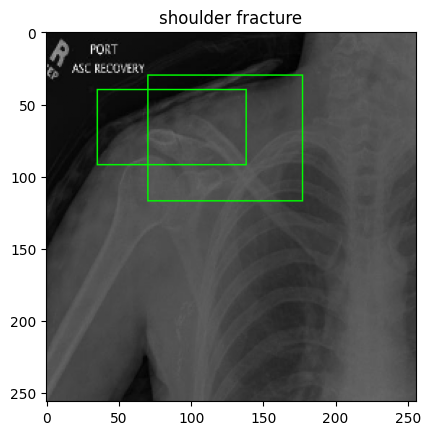

In [ ]:
idx=random.randint(0,len(image)-1)
img, tar = image[idx].permute(1,2,0).numpy(), target[idx]

for bbox in tar['boxes']:
    xmin,ymin,xmax,ymax=bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
    sp,ep=(xmin,ymin),(xmax,ymax)
    cv2.rectangle(img,sp,ep,(0,255,0),1)

plt.imshow(img)
plt.title(l2c[tar['labels'][0].item()])
plt.show()

## Model Faster RCNN- ResNet

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model=torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(D);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [ ]:
def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0

    for images, targets in tqdm(dataloader):
        image=[i.to(D) for i in images]
        target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

        opt.zero_grad()
        losses=model(image,target)
        loss=sum(loss for loss in losses.values())
        loss.backward()
        opt.step()

        train_loss+=loss
    return train_loss/len(dataloader)

def evalarc(model, dataloader):
    model.train()
    val_loss=0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            image=[i.to(D) for i in images]
            target=[{k:v.to(D) for k,v in ele.items()} for ele in targets]

            losses=model(image,target)
            loss=sum( loss for loss in losses.values() )

            val_loss+=loss
    return val_loss/len(dataloader)

In [ ]:
LR=0.00003
epochs=15

best_val_loss=np.inf

opt=torch.optim.Adam(model.parameters(),lr=LR)

for i in range(epochs):
    train_loss=trainarc(model,trainloader,opt)
    val_loss=evalarc(model,valloader)

    print(f"Epochs: {i+1}/{epochs}:- Trainloss: {train_loss}, Valloss: {val_loss}")

    if val_loss<best_val_loss:
        torch.save(model.state_dict(),'/content/drive/MyDrive/BoneFractureYolo8/Fast RCNN/model.pt')
        print("Model Updated")
        best_val_loss=val_loss

torch.save(model.state_dict(),'/content/drive/MyDrive/BoneFractureYolo8/Fast RCNN/FullyTrainedModel.pt')
print("Fully Trained Model Saved")
print(f"Done. Best Val Loss: {best_val_loss}")


100%|██████████| 22/22 [04:04<00:00, 11.11s/it]


Epochs: 1/15:- Trainloss: 0.4093123972415924, Valloss: 0.39811572432518005
Model Updated


100%|██████████| 22/22 [00:39<00:00,  1.79s/it]


Epochs: 2/15:- Trainloss: 0.3698546588420868, Valloss: 0.36946752667427063
Model Updated


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 3/15:- Trainloss: 0.3695437014102936, Valloss: 0.38331925868988037


100%|██████████| 22/22 [00:38<00:00,  1.77s/it]


Epochs: 4/15:- Trainloss: 0.35474690794944763, Valloss: 0.3882375657558441


100%|██████████| 22/22 [00:39<00:00,  1.77s/it]


Epochs: 5/15:- Trainloss: 0.3521912097930908, Valloss: 0.3812243938446045


100%|██████████| 22/22 [00:38<00:00,  1.77s/it]


Epochs: 6/15:- Trainloss: 0.3386802077293396, Valloss: 0.3762003481388092


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 7/15:- Trainloss: 0.3347505033016205, Valloss: 0.4334367513656616


100%|██████████| 22/22 [00:39<00:00,  1.82s/it]


Epochs: 8/15:- Trainloss: 0.3358113467693329, Valloss: 0.3600320816040039
Model Updated


100%|██████████| 22/22 [00:39<00:00,  1.80s/it]


Epochs: 9/15:- Trainloss: 0.31860724091529846, Valloss: 0.3976965546607971


100%|██████████| 22/22 [00:39<00:00,  1.80s/it]


Epochs: 10/15:- Trainloss: 0.30930155515670776, Valloss: 0.41180619597435


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 11/15:- Trainloss: 0.2940281927585602, Valloss: 0.3976339101791382


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 12/15:- Trainloss: 0.2768670916557312, Valloss: 0.3397022783756256
Model Updated


100%|██████████| 22/22 [00:38<00:00,  1.77s/it]


Epochs: 13/15:- Trainloss: 0.2653067409992218, Valloss: 0.36947813630104065


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 14/15:- Trainloss: 0.2528753876686096, Valloss: 0.35410866141319275


100%|██████████| 22/22 [00:39<00:00,  1.78s/it]


Epochs: 15/15:- Trainloss: 0.24295011162757874, Valloss: 0.37148311734199524
Fully Trained Model Saved
Done. Best Val Loss: 0.3397022783756256


### Iterasi ke data validasi

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for i in range(len(valset)):
  test_img,test_tar=valset[i]
  model.eval()
  pred=model(test_img.unsqueeze(0).to(D))
  # pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
  # xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
  out=pred[0]['labels'][0].item()
  y_pred.append(out)
  org=test_tar['labels'][0].item()
  y_true.append(org)

<ipython-input-19-946e825ff1b2>:2: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],


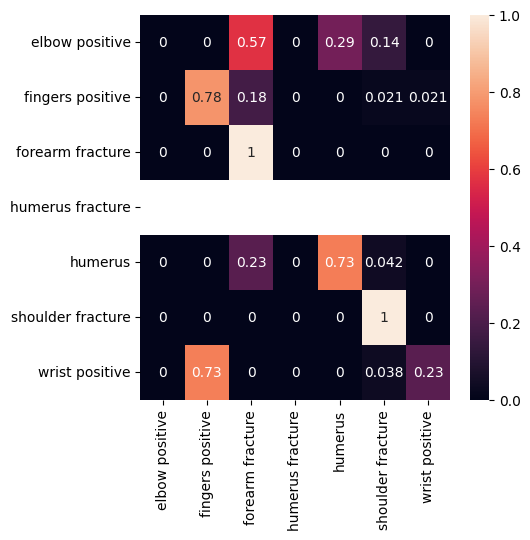

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
accuracy = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3077


## On Test Data

### Load data test

In [ ]:
test_dir_path='/content/drive/MyDrive/BoneFractureYolo8/test'
test_img_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/test/images'))
test_target_paths = sorted(os.listdir('/content/drive/MyDrive/BoneFractureYolo8/test/labels'))

testset=FractureData(test_dir_path, test_img_paths, test_target_paths, augs)

### iterasi ke data test

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for i in range(len(testset)):
  test_img,test_tar=testset[i]
  model.eval()
  pred=model(test_img.unsqueeze(0).to(D))
  # pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
  # xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
  out=pred[0]['labels'][0].item()
  y_pred.append(out)
  org=test_tar['labels'][0].item()
  y_true.append(org)


<ipython-input-22-747a13dee9dd>:2: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],


<Axes: >

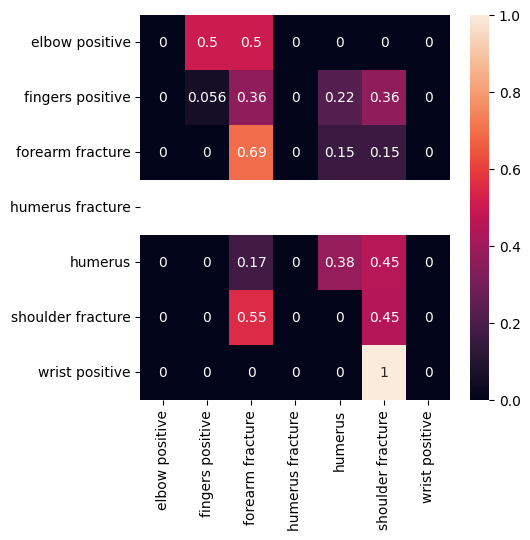

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

In [ ]:
accuracy = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.3077


### test gambar random

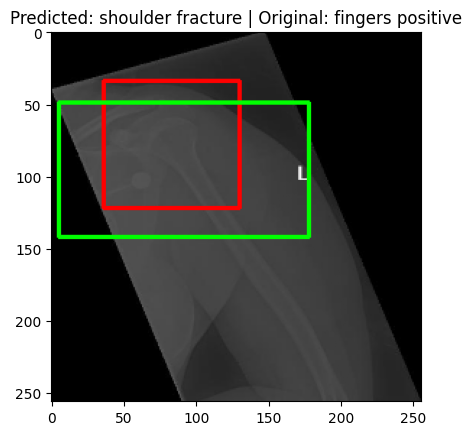

In [ ]:
idx=random.randint(0,len(testset)-1)
# print(idx)
test_img,test_tar=testset[idx]
# print(test_tar) #type-dict

model.eval()

pred=model(test_img.unsqueeze(0).to(D))
# print(pred) #type-list

# pred=torchvision.ops.nms(pred[0]['boxes'].detach(),pred[0]['scores'].detach(),0.02)
xmin,ymin,xmax,ymax=pred[0]['boxes'][0].detach().cpu().long().tolist()
pred_label=pred[0]['labels'][0].item()
orig_label=test_tar['labels'][0].item()

Txmin,Tymin,Txmax,Tymax=test_tar['boxes'][0].tolist()

#predicted rectangle
image=cv2.rectangle(test_img.permute(1,2,0).numpy(),(xmin,ymin),(xmax,ymax),(255,0,0),2)

#original rectangle
image=cv2.rectangle(image,(Txmin,Tymin),(Txmax,Tymax),(0,255,0),2)

plt.imshow(image)
plt.title("Predicted: " + str(l2c[pred_label]) + " | Original: " +str(l2c[orig_label]))
plt.show()